<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 19 14:04:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   33C    P0    28W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
def train_model(convert_color, original=False, preprocess=False):
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.resnet.ResNet101(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.resnet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.resnet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
171458560/171446536 [==============================] - 138s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 31s 59ms/step - loss: 0.6730 - accuracy: 0.7486 - val_loss: 0.4399 - val_accuracy: 0.8140
Epoch 2/100
360/360 [==============================] - 21s 59ms/step - loss: 0.4917 - accuracy: 0.7957 - val_loss: 0.4045 - val_accuracy: 0.8310
Epoch 3/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4475 - accuracy: 0.8128 - val_loss: 0.4274 - val_accuracy: 0.8189
Epoch 4/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4365 - accuracy: 0.8196 - val_loss: 0.3972 - val_accuracy: 0.8371
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4181 - accuracy: 0.8309 - val_loss: 0.4087 - val_accuracy: 0.8237
Epoch 6/100
360/

Epoch 54/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2980 - accuracy: 0.8804 - val_loss: 0.3176 - val_accuracy: 0.8736
Epoch 55/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3004 - accuracy: 0.8793 - val_loss: 0.3130 - val_accuracy: 0.8770
Epoch 56/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2962 - accuracy: 0.8797 - val_loss: 0.3193 - val_accuracy: 0.8744
Epoch 57/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2887 - accuracy: 0.8850 - val_loss: 0.3201 - val_accuracy: 0.8744
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2965 - accuracy: 0.8830 - val_loss: 0.3144 - val_accuracy: 0.8743
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2897 - accuracy: 0.8853 - val_loss: 0.3218 - val_accuracy: 0.8668
Epoch 60/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2937 - accuracy: 0.8838 - val_loss: 0.3112 -

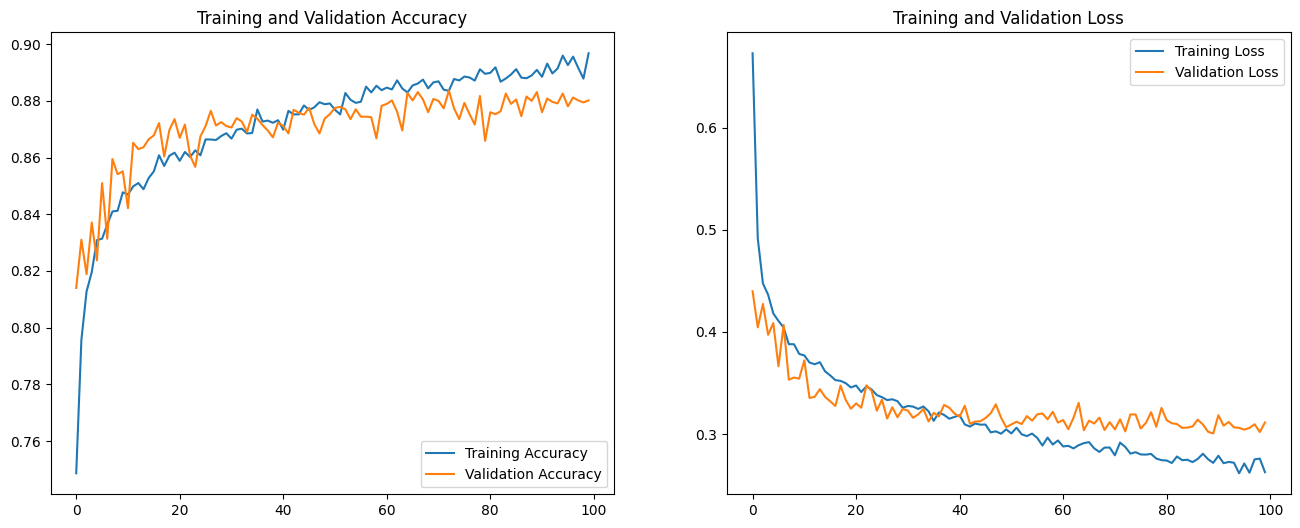

In [4]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 60ms/step - loss: 0.7687 - accuracy: 0.7094 - val_loss: 0.5470 - val_accuracy: 0.7683
Epoch 2/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5651 - accuracy: 0.7630 - val_loss: 0.4903 - val_accuracy: 0.8015
Epoch 3/100
360/360 [==============================] - 20s 57ms/step - loss: 0.5364 - accuracy: 0.7754 - val_loss: 0.4682 - val_accuracy: 0.8048
Epoch 4/100
360/360 [==============================] - 21s 58ms/step - loss: 0.5207 - accuracy: 0.7848 - val_loss: 0.4485 - val_accuracy: 0.8171
Epoch 5/100
360/360 [==============================] - 21s 59ms/step - loss: 0.5069 - accuracy: 0.7884 - val_loss: 0.4725 - val_accuracy: 0.8072
Epoch 6/100
360/360 [==============================] - 20s 56ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3610 - accuracy: 0.8568 - val_loss: 0.3919 - val_accuracy: 0.8545
Epoch 57/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3654 - accuracy: 0.8511 - val_loss: 0.3962 - val_accuracy: 0.8447
Epoch 58/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3587 - accuracy: 0.8544 - val_loss: 0.3899 - val_accuracy: 0.8473
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3598 - accuracy: 0.8550 - val_loss: 0.3842 - val_accuracy: 0.8536
Epoch 60/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3557 - accuracy: 0.8561 - val_loss: 0.3833 - val_accuracy: 0.8565
Epoch 61/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3535 - accuracy: 0.8564 - val_loss: 0.3859 - val_accuracy: 0.8557
Epoch 62/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3569 - accuracy: 0.8572 - val_loss: 0.3829 -

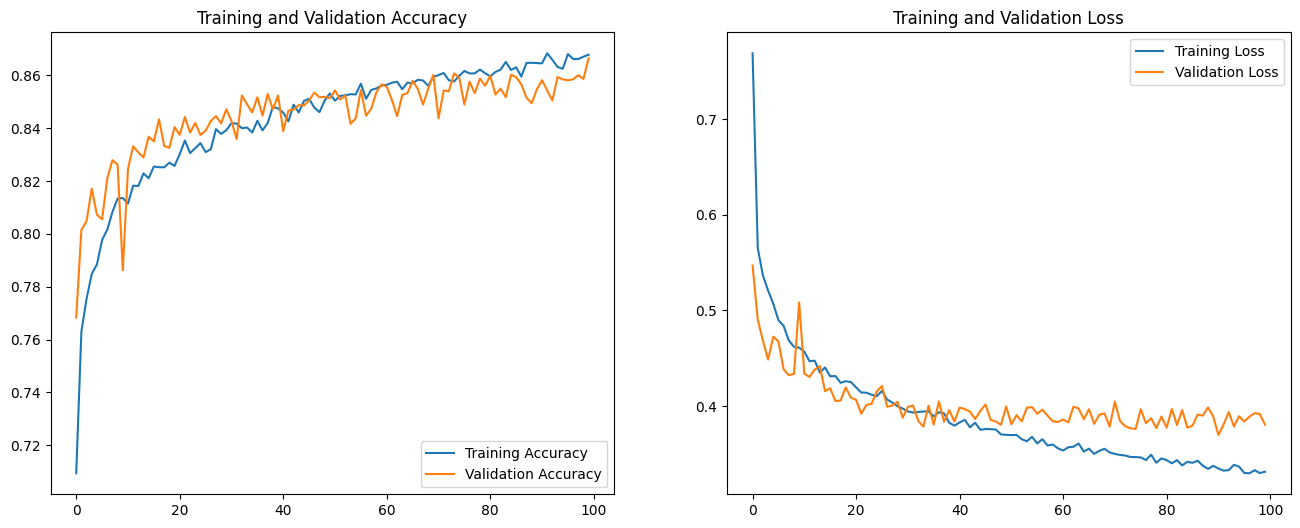

In [5]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 29s 60ms/step - loss: 0.7683 - accuracy: 0.6970 - val_loss: 0.5585 - val_accuracy: 0.7701
Epoch 2/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5972 - accuracy: 0.7531 - val_loss: 0.5326 - val_accuracy: 0.7815
Epoch 3/100
360/360 [==============================] - 20s 57ms/step - loss: 0.5721 - accuracy: 0.7652 - val_loss: 0.5093 - val_accuracy: 0.7860
Epoch 4/100
360/360 [==============================] - 20s 57ms/step - loss: 0.5581 - accuracy: 0.7703 - val_loss: 0.5000 - val_accuracy: 0.7942
Epoch 5/100
360/360 [==============================] - 20s 57ms/step - loss: 0.5416 - accuracy: 0.7790 - val_loss: 0.4900 - val_accuracy: 0.8006
Epoch 6/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5205 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4056 - accuracy: 0.8361 - val_loss: 0.4239 - val_accuracy: 0.8321
Epoch 57/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3962 - accuracy: 0.8402 - val_loss: 0.4366 - val_accuracy: 0.8321
Epoch 58/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3959 - accuracy: 0.8405 - val_loss: 0.4258 - val_accuracy: 0.8350
Epoch 59/100
360/360 [==============================] - 20s 54ms/step - loss: 0.3995 - accuracy: 0.8388 - val_loss: 0.4288 - val_accuracy: 0.8343
Epoch 60/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3917 - accuracy: 0.8415 - val_loss: 0.4505 - val_accuracy: 0.8246
Epoch 61/100
360/360 [==============================] - 20s 55ms/step - loss: 0.4020 - accuracy: 0.8401 - val_loss: 0.4404 - val_accuracy: 0.8293
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4005 - accuracy: 0.8387 - val_loss: 0.4209 -

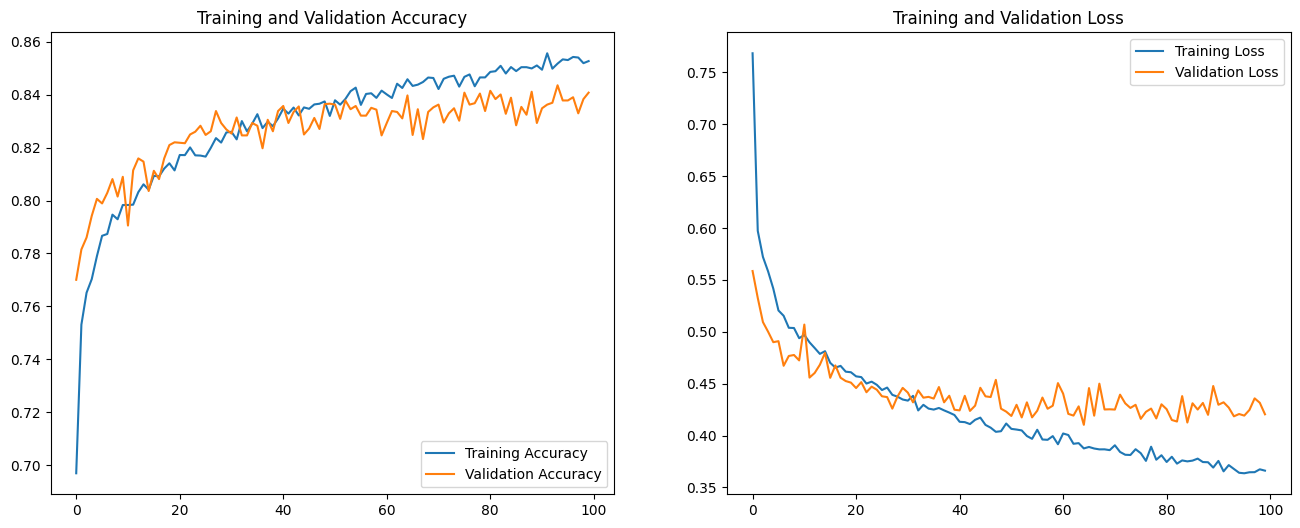

In [6]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 29s 63ms/step - loss: 1.4267 - accuracy: 0.3238 - val_loss: 1.3776 - val_accuracy: 0.3430
Epoch 2/100
360/360 [==============================] - 21s 59ms/step - loss: 1.3618 - accuracy: 0.3832 - val_loss: 1.3139 - val_accuracy: 0.4125
Epoch 3/100
360/360 [==============================] - 21s 59ms/step - loss: 1.3395 - accuracy: 0.3967 - val_loss: 1.2879 - val_accuracy: 0.4182
Epoch 4/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3251 - accuracy: 0.4037 - val_loss: 1.3196 - val_accuracy: 0.3953
Epoch 5/100
360/360 [==============================] - 20s 54ms/step - loss: 1.3131 - accuracy: 0.4132 - val_loss: 1.2700 - val_accuracy: 0.4274
Epoch 6/100
360/360 [==============================] - 20s 55ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 20s 55ms/step - loss: 1.1097 - accuracy: 0.5354 - val_loss: 1.0050 - val_accuracy: 0.5844
Epoch 57/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1073 - accuracy: 0.5310 - val_loss: 1.0199 - val_accuracy: 0.5714
Epoch 58/100
360/360 [==============================] - 20s 54ms/step - loss: 1.1103 - accuracy: 0.5313 - val_loss: 1.0161 - val_accuracy: 0.5915
Epoch 59/100
360/360 [==============================] - 20s 54ms/step - loss: 1.1000 - accuracy: 0.5352 - val_loss: 1.0232 - val_accuracy: 0.5740
Epoch 60/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1050 - accuracy: 0.5353 - val_loss: 1.0284 - val_accuracy: 0.5733
Epoch 61/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1013 - accuracy: 0.5339 - val_loss: 1.0202 - val_accuracy: 0.5830
Epoch 62/100
360/360 [==============================] - 20s 54ms/step - loss: 1.1067 - accuracy: 0.5331 - val_loss: 1.0062 -

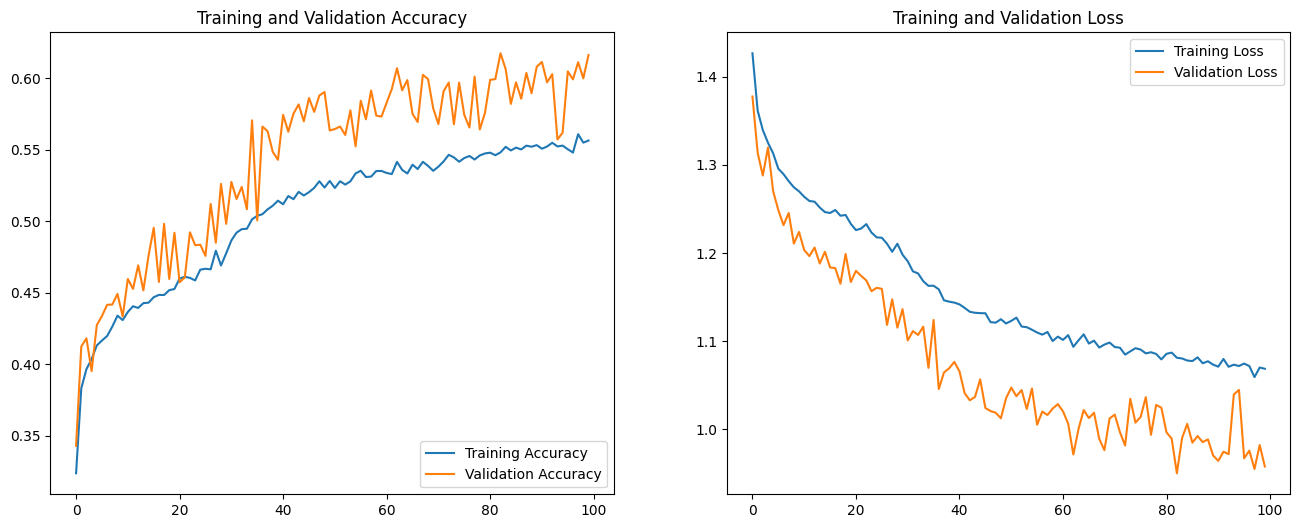

In [7]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 59ms/step - loss: 1.4209 - accuracy: 0.3271 - val_loss: 1.3560 - val_accuracy: 0.3880
Epoch 2/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3708 - accuracy: 0.3674 - val_loss: 1.3187 - val_accuracy: 0.3963
Epoch 3/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3444 - accuracy: 0.3860 - val_loss: 1.2881 - val_accuracy: 0.4047
Epoch 4/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3215 - accuracy: 0.3987 - val_loss: 1.2486 - val_accuracy: 0.4264
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2971 - accuracy: 0.4145 - val_loss: 1.2325 - val_accuracy: 0.4227
Epoch 6/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2847 - accuracy: 0.4

Epoch 56/100
360/360 [==============================] - 20s 55ms/step - loss: 1.1144 - accuracy: 0.5180 - val_loss: 1.0290 - val_accuracy: 0.5518
Epoch 57/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1072 - accuracy: 0.5241 - val_loss: 0.9862 - val_accuracy: 0.5983
Epoch 58/100
360/360 [==============================] - 19s 54ms/step - loss: 1.0941 - accuracy: 0.5300 - val_loss: 1.0516 - val_accuracy: 0.5281
Epoch 59/100
360/360 [==============================] - 20s 54ms/step - loss: 1.1072 - accuracy: 0.5234 - val_loss: 1.0347 - val_accuracy: 0.5365
Epoch 60/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1003 - accuracy: 0.5307 - val_loss: 1.0315 - val_accuracy: 0.5667
Epoch 61/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1001 - accuracy: 0.5231 - val_loss: 0.9907 - val_accuracy: 0.5853
Epoch 62/100
360/360 [==============================] - 20s 55ms/step - loss: 1.1057 - accuracy: 0.5265 - val_loss: 0.9946 -

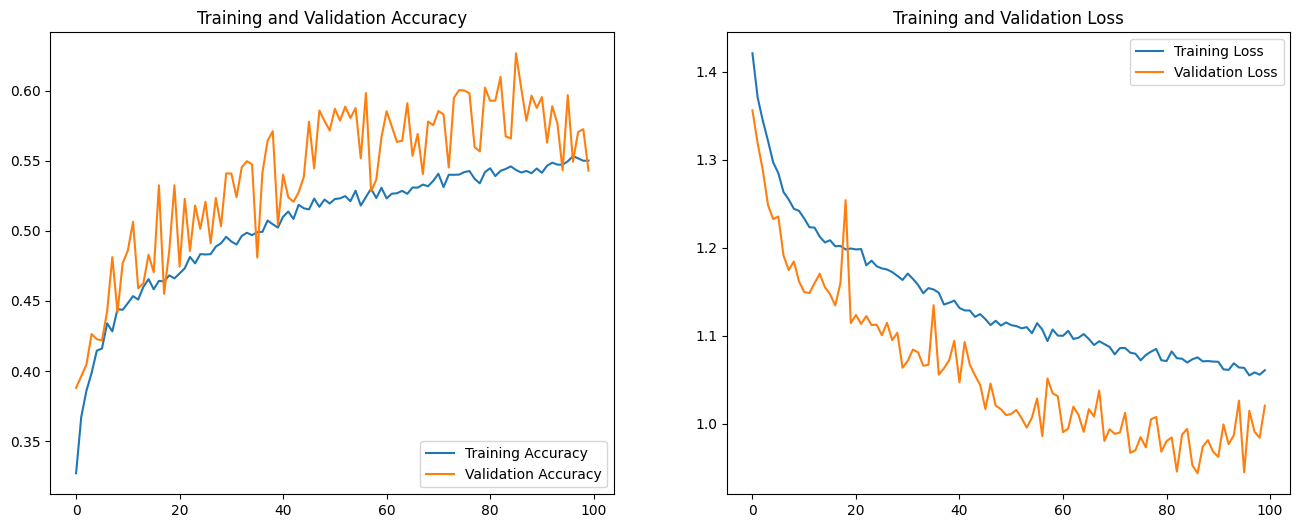

In [8]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 27s 57ms/step - loss: 1.3114 - accuracy: 0.4043 - val_loss: 1.1713 - val_accuracy: 0.4738
Epoch 2/100
360/360 [==============================] - 19s 53ms/step - loss: 1.2134 - accuracy: 0.4492 - val_loss: 1.1674 - val_accuracy: 0.4618
Epoch 3/100
360/360 [==============================] - 20s 54ms/step - loss: 1.1786 - accuracy: 0.4704 - val_loss: 1.1045 - val_accuracy: 0.5184
Epoch 4/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1643 - accuracy: 0.4760 - val_loss: 1.1596 - val_accuracy: 0.4936
Epoch 5/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1435 - accuracy: 0.4885 - val_loss: 1.0624 - val_accuracy: 0.5259
Epoch 6/100
360/360 [==============================] - 19s 52ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 19s 54ms/step - loss: 1.0722 - accuracy: 0.5278 - val_loss: 0.9998 - val_accuracy: 0.5526
Epoch 57/100
360/360 [==============================] - 19s 54ms/step - loss: 1.0723 - accuracy: 0.5269 - val_loss: 0.9917 - val_accuracy: 0.5512
Epoch 58/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0753 - accuracy: 0.5261 - val_loss: 0.9945 - val_accuracy: 0.5564
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0756 - accuracy: 0.5236 - val_loss: 1.0052 - val_accuracy: 0.5509
Epoch 60/100
360/360 [==============================] - 19s 54ms/step - loss: 1.0693 - accuracy: 0.5280 - val_loss: 0.9905 - val_accuracy: 0.5589
Epoch 61/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0741 - accuracy: 0.5247 - val_loss: 1.0223 - val_accuracy: 0.5596
Epoch 62/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0730 - accuracy: 0.5237 - val_loss: 0.9817 -

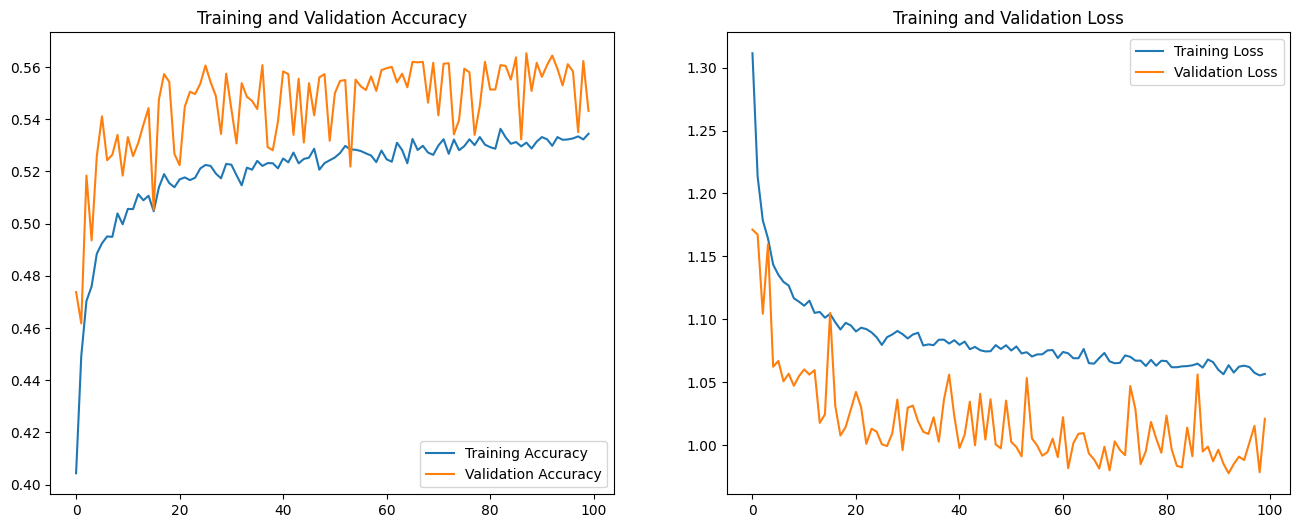

In [9]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 59ms/step - loss: 1.2668 - accuracy: 0.4028 - val_loss: 1.1912 - val_accuracy: 0.4658
Epoch 2/100
360/360 [==============================] - 20s 56ms/step - loss: 1.1897 - accuracy: 0.4617 - val_loss: 1.1803 - val_accuracy: 0.4713
Epoch 3/100
360/360 [==============================] - 19s 52ms/step - loss: 1.1668 - accuracy: 0.4712 - val_loss: 1.1364 - val_accuracy: 0.4986
Epoch 4/100
360/360 [==============================] - 19s 53ms/step - loss: 1.1575 - accuracy: 0.4816 - val_loss: 1.1326 - val_accuracy: 0.4891
Epoch 5/100
360/360 [==============================] - 19s 52ms/step - loss: 1.1448 - accuracy: 0.4864 - val_loss: 1.1286 - val_accuracy: 0.5007
Epoch 6/100
360/360 [==============================] - 19s 53ms/step - loss: 1.1343 - accuracy: 0.4

Epoch 56/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0711 - accuracy: 0.5285 - val_loss: 1.1660 - val_accuracy: 0.4828
Epoch 57/100
360/360 [==============================] - 19s 52ms/step - loss: 1.0723 - accuracy: 0.5291 - val_loss: 1.1183 - val_accuracy: 0.5007
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 1.0815 - accuracy: 0.5228 - val_loss: 1.0716 - val_accuracy: 0.5193
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0784 - accuracy: 0.5242 - val_loss: 1.0926 - val_accuracy: 0.5254
Epoch 60/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0728 - accuracy: 0.5261 - val_loss: 1.1018 - val_accuracy: 0.5167
Epoch 61/100
360/360 [==============================] - 21s 58ms/step - loss: 1.0744 - accuracy: 0.5256 - val_loss: 1.0803 - val_accuracy: 0.5229
Epoch 62/100
360/360 [==============================] - 19s 53ms/step - loss: 1.0730 - accuracy: 0.5265 - val_loss: 1.0359 -

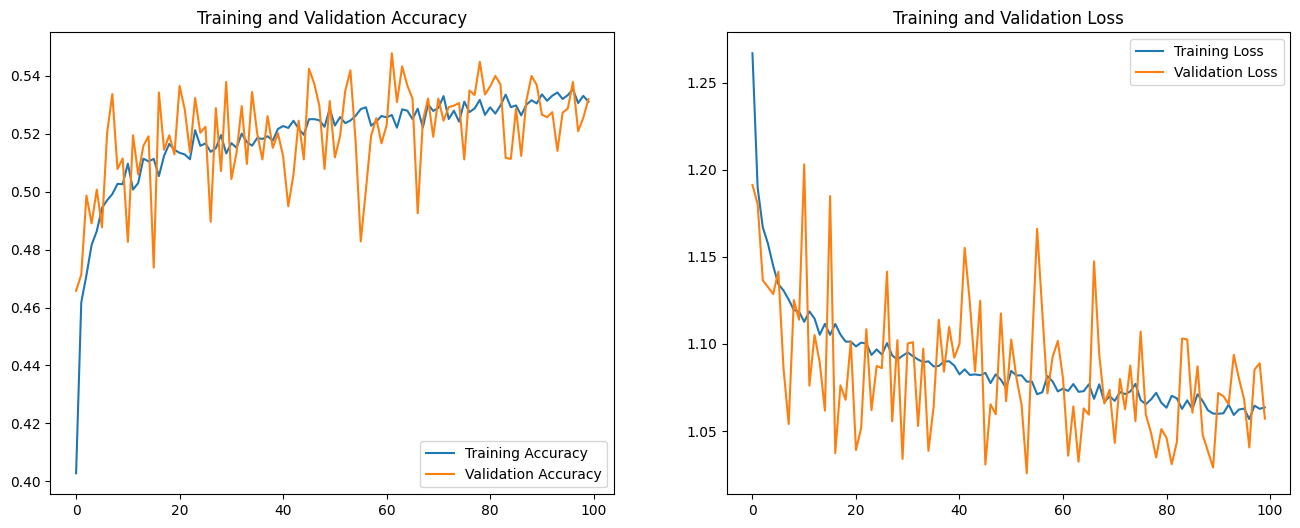

In [10]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 59ms/step - loss: 1.4521 - accuracy: 0.2824 - val_loss: 1.4152 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 20s 54ms/step - loss: 1.4292 - accuracy: 0.2896 - val_loss: 1.4167 - val_accuracy: 0.2890
Epoch 3/100
360/360 [==============================] - 20s 55ms/step - loss: 1.4240 - accuracy: 0.2883 - val_loss: 1.4120 - val_accuracy: 0.2746
Epoch 4/100
360/360 [==============================] - 19s 54ms/step - loss: 1.4184 - accuracy: 0.2864 - val_loss: 1.4067 - val_accuracy: 0.2746
Epoch 5/100
360/360 [==============================] - 21s 58ms/step - loss: 1.4138 - accuracy: 0.2882 - val_loss: 1.3907 - val_accuracy: 0.2864
Epoch 6/100
360/360 [==============================] - 20s 57ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 19s 54ms/step - loss: 1.3127 - accuracy: 0.3549 - val_loss: 1.3024 - val_accuracy: 0.3286
Epoch 57/100
360/360 [==============================] - 19s 54ms/step - loss: 1.3046 - accuracy: 0.3598 - val_loss: 1.2239 - val_accuracy: 0.4529
Epoch 58/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3051 - accuracy: 0.3608 - val_loss: 1.2858 - val_accuracy: 0.3526
Epoch 59/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3067 - accuracy: 0.3624 - val_loss: 1.2587 - val_accuracy: 0.3758
Epoch 60/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2999 - accuracy: 0.3652 - val_loss: 1.2803 - val_accuracy: 0.3421
Epoch 61/100
360/360 [==============================] - 19s 54ms/step - loss: 1.3045 - accuracy: 0.3677 - val_loss: 1.2820 - val_accuracy: 0.3175
Epoch 62/100
360/360 [==============================] - 19s 54ms/step - loss: 1.2961 - accuracy: 0.3737 - val_loss: 1.2323 -

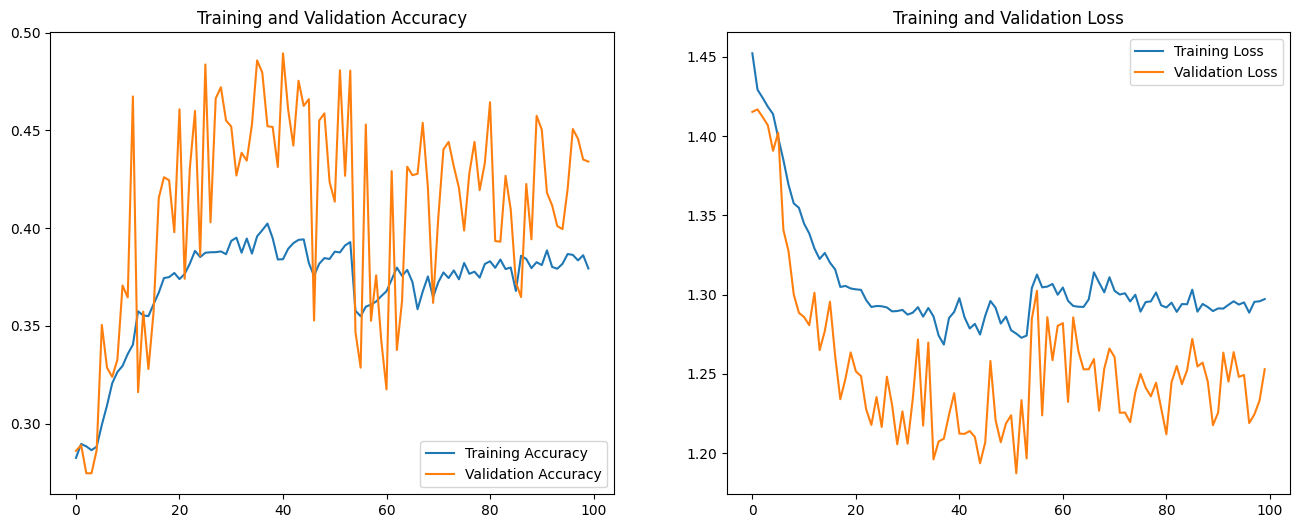

In [11]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 29s 63ms/step - loss: 1.4427 - accuracy: 0.2881 - val_loss: 1.4120 - val_accuracy: 0.2746
Epoch 2/100
360/360 [==============================] - 19s 54ms/step - loss: 1.4255 - accuracy: 0.2904 - val_loss: 1.4170 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 20s 56ms/step - loss: 1.4223 - accuracy: 0.2936 - val_loss: 1.4093 - val_accuracy: 0.2892
Epoch 4/100
360/360 [==============================] - 20s 56ms/step - loss: 1.4199 - accuracy: 0.2944 - val_loss: 1.4082 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 20s 55ms/step - loss: 1.4144 - accuracy: 0.3015 - val_loss: 1.3966 - val_accuracy: 0.2940
Epoch 6/100
360/360 [==============================] - 20s 55ms/step - loss: 1.4088 - accuracy: 0.3

Epoch 56/100
360/360 [==============================] - 20s 54ms/step - loss: 1.2520 - accuracy: 0.4307 - val_loss: 1.1565 - val_accuracy: 0.4866
Epoch 57/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2514 - accuracy: 0.4332 - val_loss: 1.1509 - val_accuracy: 0.4934
Epoch 58/100
360/360 [==============================] - 20s 54ms/step - loss: 1.2549 - accuracy: 0.4293 - val_loss: 1.1808 - val_accuracy: 0.4680
Epoch 59/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2536 - accuracy: 0.4267 - val_loss: 1.2139 - val_accuracy: 0.4328
Epoch 60/100
360/360 [==============================] - 20s 56ms/step - loss: 1.2619 - accuracy: 0.4216 - val_loss: 1.1951 - val_accuracy: 0.4682
Epoch 61/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2612 - accuracy: 0.4231 - val_loss: 1.1640 - val_accuracy: 0.5031
Epoch 62/100
360/360 [==============================] - 20s 54ms/step - loss: 1.2577 - accuracy: 0.4227 - val_loss: 1.1421 -

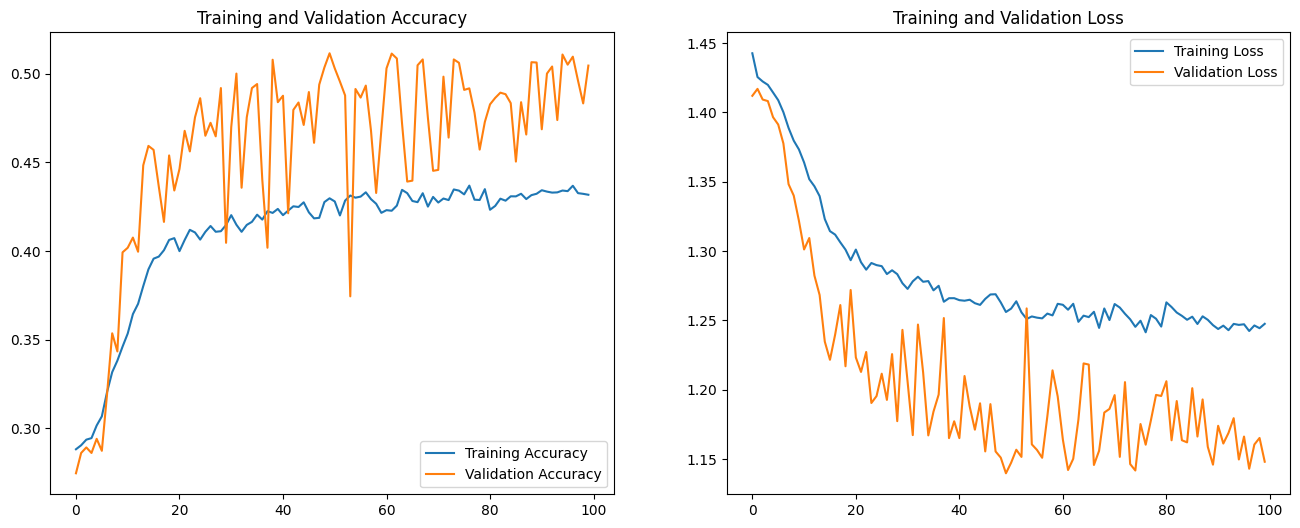

In [12]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 28s 58ms/step - loss: 1.4513 - accuracy: 0.2839 - val_loss: 1.4438 - val_accuracy: 0.3222
Epoch 2/100
360/360 [==============================] - 20s 55ms/step - loss: 1.4245 - accuracy: 0.2909 - val_loss: 1.4169 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 20s 54ms/step - loss: 1.4190 - accuracy: 0.2955 - val_loss: 1.3961 - val_accuracy: 0.2862
Epoch 4/100
360/360 [==============================] - 20s 55ms/step - loss: 1.4047 - accuracy: 0.3129 - val_loss: 1.3705 - val_accuracy: 0.3392
Epoch 5/100
360/360 [==============================] - 20s 56ms/step - loss: 1.3833 - accuracy: 0.3304 - val_loss: 1.3183 - val_accuracy: 0.4225
Epoch 6/100
360/360 [==============================] - 20s 55ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2441 - accuracy: 0.4331 - val_loss: 1.1783 - val_accuracy: 0.4649
Epoch 57/100
360/360 [==============================] - 19s 54ms/step - loss: 1.2416 - accuracy: 0.4393 - val_loss: 1.1941 - val_accuracy: 0.4493
Epoch 58/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2427 - accuracy: 0.4337 - val_loss: 1.1933 - val_accuracy: 0.4394
Epoch 59/100
360/360 [==============================] - 20s 54ms/step - loss: 1.2582 - accuracy: 0.4251 - val_loss: 1.1625 - val_accuracy: 0.5030
Epoch 60/100
360/360 [==============================] - 19s 54ms/step - loss: 1.2413 - accuracy: 0.4342 - val_loss: 1.1527 - val_accuracy: 0.5021
Epoch 61/100
360/360 [==============================] - 19s 54ms/step - loss: 1.2567 - accuracy: 0.4251 - val_loss: 1.2407 - val_accuracy: 0.4151
Epoch 62/100
360/360 [==============================] - 20s 55ms/step - loss: 1.2657 - accuracy: 0.4219 - val_loss: 1.2138 -

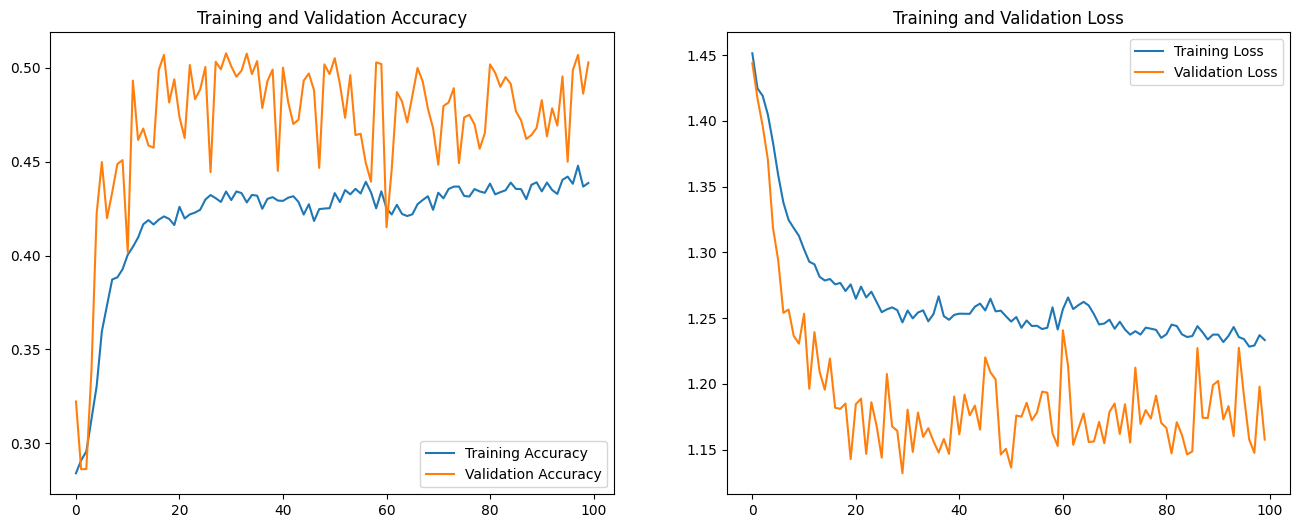

In [13]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 28s 59ms/step - loss: 1.4365 - accuracy: 0.2915 - val_loss: 1.4000 - val_accuracy: 0.3397
Epoch 2/100
360/360 [==============================] - 19s 54ms/step - loss: 1.4129 - accuracy: 0.3096 - val_loss: 1.3858 - val_accuracy: 0.2951
Epoch 3/100
360/360 [==============================] - 19s 54ms/step - loss: 1.3871 - accuracy: 0.3381 - val_loss: 1.3309 - val_accuracy: 0.3715
Epoch 4/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3646 - accuracy: 0.3562 - val_loss: 1.3212 - val_accuracy: 0.3798
Epoch 5/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3365 - accuracy: 0.3760 - val_loss: 1.2675 - val_accuracy: 0.3986
Epoch 6/100
360/360 [==============================] - 20s 55ms/step - loss: 1.3207 - accuracy: 0.3

Epoch 56/100
360/360 [==============================] - 20s 55ms/step - loss: 1.1997 - accuracy: 0.4624 - val_loss: 1.0972 - val_accuracy: 0.5205
Epoch 57/100
360/360 [==============================] - 20s 54ms/step - loss: 1.1983 - accuracy: 0.4676 - val_loss: 1.0810 - val_accuracy: 0.5347
Epoch 58/100
360/360 [==============================] - 20s 54ms/step - loss: 1.2026 - accuracy: 0.4637 - val_loss: 1.0982 - val_accuracy: 0.5052
Epoch 59/100
360/360 [==============================] - 19s 54ms/step - loss: 1.2081 - accuracy: 0.4610 - val_loss: 1.1001 - val_accuracy: 0.5401
Epoch 60/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1983 - accuracy: 0.4693 - val_loss: 1.0921 - val_accuracy: 0.5304
Epoch 61/100
360/360 [==============================] - 20s 54ms/step - loss: 1.2000 - accuracy: 0.4665 - val_loss: 1.1074 - val_accuracy: 0.5240
Epoch 62/100
360/360 [==============================] - 19s 54ms/step - loss: 1.1990 - accuracy: 0.4675 - val_loss: 1.0885 -

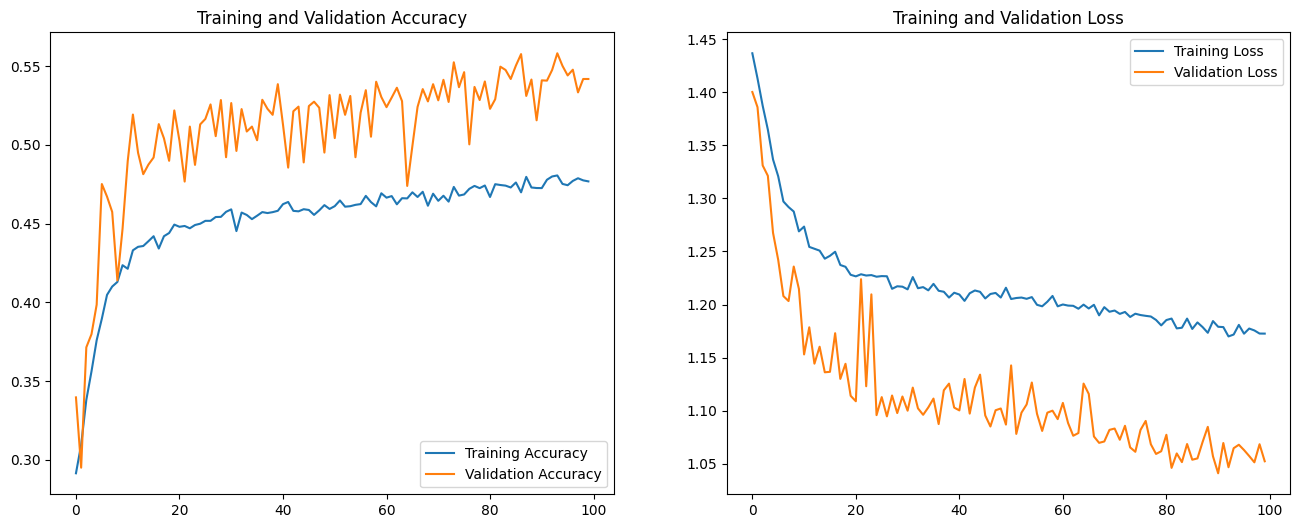

In [14]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [16]:
# !mkdir resnet101_nontrainable
# pd.DataFrame(res_rgb).to_csv("resnet101_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("resnet101_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("resnet101_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("resnet101_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("resnet101_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("resnet101_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("resnet101_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("resnet101_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("resnet101_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("resnet101_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("resnet101_nontrainable/res_ydbdr_nonpre.csv", index=False)